### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET ='/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 5e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))

Train data shape: (3614, 25)
Test data shape: (1549, 25)


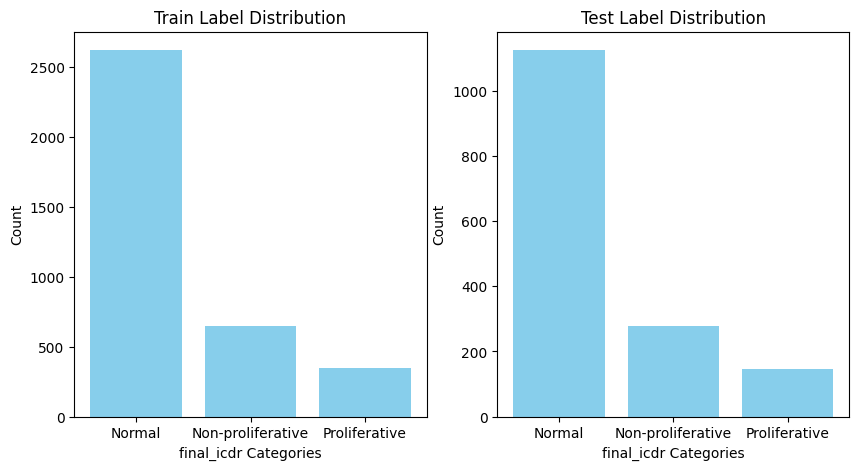

Getting validation set...
Train data shape: (1239, 25)
Test data shape: (310, 25)


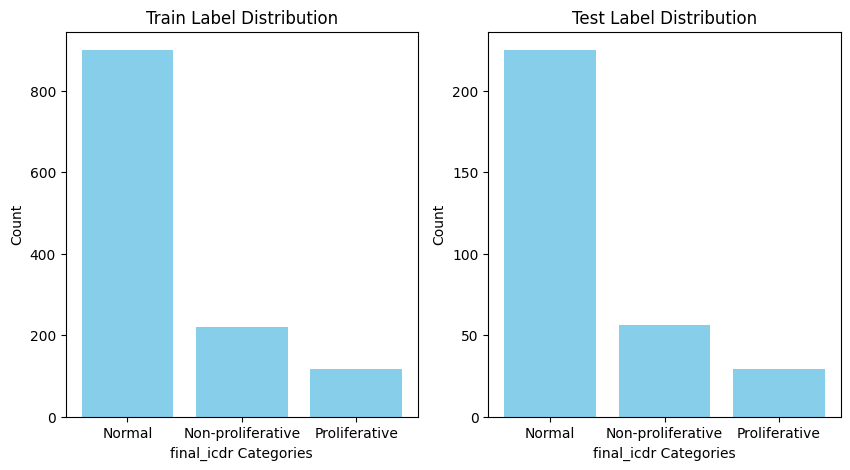

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

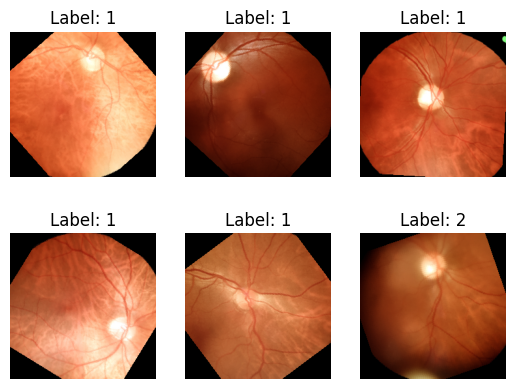

In [10]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [11]:
# Create a DataLoader to generate embeddings
model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
#backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
#model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Model = VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Att

### Training:

In [12]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [13]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_3class_{LABEL}')

100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 1, Train Loss: 1.06483065053425, Val Loss: 0.9361073404550553, F1 Score: 0.5094529116890703


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 2, Train Loss: 0.963156537144585, Val Loss: 0.876225259900093, F1 Score: 0.5340510959444192


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 3, Train Loss: 0.9081893261291284, Val Loss: 0.9039716213941574, F1 Score: 0.5844249400902689


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 4, Train Loss: 0.8530439170060959, Val Loss: 0.9379832476377488, F1 Score: 0.42056765185222783


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 5, Train Loss: 0.8042932449452644, Val Loss: 0.9234869599342346, F1 Score: 0.4482410462898489


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 6, Train Loss: 0.8043979910095181, Val Loss: 0.7499018162488937, F1 Score: 0.586718976820169


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Epoch 7, Train Loss: 0.7656532510191993, Val Loss: 0.7526041001081467, F1 Score: 0.5662914135890097


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 8, Train Loss: 0.7393420419729917, Val Loss: 0.7802649527788162, F1 Score: 0.5197624779329161


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 9, Train Loss: 0.693499468464767, Val Loss: 0.6605361253023148, F1 Score: 0.573042643630879


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 10, Train Loss: 0.6980491691326673, Val Loss: 0.7939054489135742, F1 Score: 0.6182167961524233


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Epoch 11, Train Loss: 0.6798994665784118, Val Loss: 0.6961411893367767, F1 Score: 0.5895503234085911


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 12, Train Loss: 0.6546572988803407, Val Loss: 0.7258671283721924, F1 Score: 0.5828373015873015


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Epoch 13, Train Loss: 0.6382271034923275, Val Loss: 0.6598246604204178, F1 Score: 0.5794883657945951


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Epoch 14, Train Loss: 0.6008011361798354, Val Loss: 0.700990554690361, F1 Score: 0.5981307685997503


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 15, Train Loss: 0.6127726355880763, Val Loss: 0.7514344424009323, F1 Score: 0.6144823711195393


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 16, Train Loss: 0.5813794646379167, Val Loss: 0.7496125504374505, F1 Score: 0.5836648125962428


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Epoch 17, Train Loss: 0.5527025217239836, Val Loss: 0.7273343294858933, F1 Score: 0.5402669495903171
Early stopping triggered.


In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

# Metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

# Generate Saliency Maps
def get_saliency_map(model, input_image):
    model.eval()
    input_image.requires_grad_()
    output = model(input_image)
    max_idx = output.argmax()
    output[0, max_idx].backward()
    saliency_map, _ = torch.max(input_image.grad.data.abs(),dim=1)
    #saliency_map = input_image.grad.data.abs().max(1)[0]
    return saliency_map

def test_model(y_test, y_pred, y_prob=None):
    """
    Evaluates the model on the training and test data respectively
    1. Predictions on test data
    2. Classification report
    3. Confusion matrix
    4. ROC curve

    Inputs:
    y_test: numpy array with test labels
    y_pred: numpy array with predicted test labels
    """
    
    plot_matrix = False
    if y_pred.shape[1] < 102:
        plot_matrix = True
        
    
    if y_pred.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
    
    # Confusion matrix
    # Create a confusion matrix of the test predictions
    if plot_matrix:
        cm = confusion_matrix(y_test, y_pred)
        # create heatmap
        # Set the size of the plot
        fig, ax = plt.subplots(figsize=(15, 15))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
        # Set plot labels
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        # Display plot
        plt.show()
    '''
    #create ROC curve
    from sklearn.preprocessing import LabelBinarizer
    fig, ax = plt.subplots(figsize=(15, 15))

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_pred = label_binarizer.transform(y_pred)
    
    if (y_onehot_pred.shape[1] < 2):
        fpr, tpr, _ = roc_curve(y_test,  y_pred)

        #create ROC curve
        #plt.plot(fpr,tpr)
        if y_prob is not None:
            RocCurveDisplay.from_predictions(
                    y_test,
                    y_prob,
                    name=f"ROC curve",
                    color='aqua',
                    ax=ax,
                )
        else:
            RocCurveDisplay.from_predictions(
                    y_test,
                    y_pred,
                    name=f"ROC curve",
                    color='aqua',
                    ax=ax,
                )
        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.title('ROC Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    else:
        from itertools import cycle
        colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "yellow", "purple", "pink", "brown", "black"])
        if y_prob is None:
            for class_id, color in zip(range(len(label_binarizer.classes_)), colors):
                RocCurveDisplay.from_predictions(
                    y_onehot_test[:, class_id],
                    y_onehot_pred[:, class_id],
                    name=f"ROC curve for {label_binarizer.classes_[class_id]}",
                    color=color,
                    ax=ax,
                )
        else:
            for class_id, color in zip(range(len(label_binarizer.classes_)), colors):
                RocCurveDisplay.from_predictions(
                    y_onehot_test[:, class_id],
                    y_prob[:, class_id],
                    name=f"ROC curve for {label_binarizer.classes_[class_id]}",
                    color=color,
                    ax=ax,
                )

        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        plt.show()
    '''
    # Classification report
    # Create a classification report of the test predictions
    cr = classification_report(y_test, y_pred)
    # print classification report
    print(cr)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class precision
    recall = recall_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class F1-score

    return accuracy, precision, recall, f1


def test_new(model, test_dataloader, saliency=True, device='cpu', save=False):

    model.to(device)
    model.eval()

    output_size = test_dataloader.dataset.labels.shape[1]
    num_classes = 2 if test_dataloader.dataset.labels.shape[1] == 1 else test_dataloader.dataset.labels.shape[1]

    eval_images_per_class = {i: [] for i in range(num_classes)}
    
    with torch.no_grad():
        y_true, y_pred = [], []
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            image, labels =  batch['image'].to(device), batch['labels'].to(device)

            outputs = model(image)

            if (output_size == 1):
                preds = torch.sigmoid(outputs)
            else:
                preds = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Get 5 images per class for saliency maps
            for i in range(num_classes):
                if len(eval_images_per_class[i]) < 5:
                    if (output_size == 1):
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if labels[i] == i]
                    else:
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if np.argmax(labels[i].cpu().numpy()) == i]
                    
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        if (output_size == 1):
            y_pred_one_hot = (y_pred > 0.5).astype(int)
        else:
            predicted_class_indices = np.argmax(y_pred, axis=1)
            # Convert the predicted class indices to one-hot encoding
            y_pred_one_hot = np.eye(y_pred.shape[1])[predicted_class_indices]
            
        # If the output size is 2, then we just need the probabilities of the positive class
        if (output_size == 2):
            y_pred = y_pred[:, 1]
        
        test_model(y_true, y_pred_one_hot, y_pred)
    
    if saliency:
        if save:
            os.makedirs('saliency_maps', exist_ok=True)
        
        print('#' * 50, f' Saliency Maps ', '#' * 50)
        print('')

        # Select some evaluation images to generate saliency maps
        eval_images = []
        for img_class in eval_images_per_class.keys():
            eval_images = eval_images_per_class[img_class][:5]

            print(f'Class {img_class}:')
            i = 0
            for eval_image in eval_images:
                eval_image = eval_image.unsqueeze(0)  # Add batch dimension
                saliency_map = get_saliency_map(model, eval_image)

                # Plot original image and saliency map side by side
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(eval_image[0].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(f'Original Image (Class {img_class})')
                
                plt.subplot(1, 2, 2)
                plt.imshow(saliency_map[0].detach().cpu().numpy(), cmap=plt.cm.hot)
                plt.title('Saliency Map')
                
                plt.tight_layout()
                if save:
                    plt.savefig(f'saliency_maps/saliency_map_class_{img_class}_image_{i}.pdf')
                    i+=1
                    
                plt.show()


### Test

100%|██████████| 78/78 [00:23<00:00,  3.36it/s]


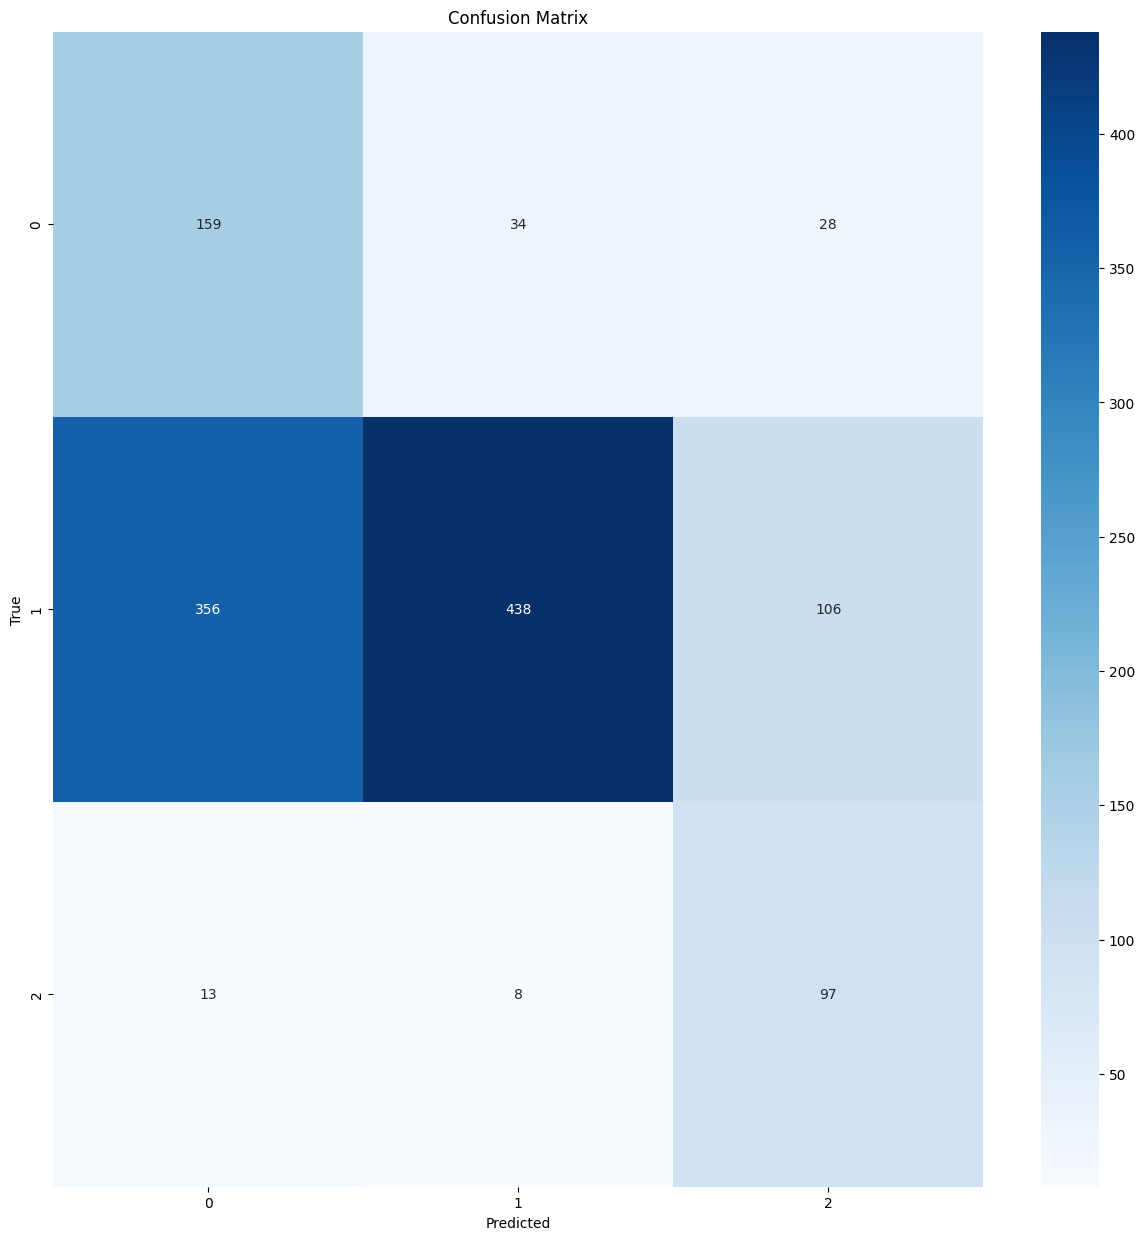

              precision    recall  f1-score   support

           0       0.30      0.72      0.42       221
           1       0.91      0.49      0.63       900
           2       0.42      0.82      0.56       118

    accuracy                           0.56      1239
   macro avg       0.54      0.68      0.54      1239
weighted avg       0.76      0.56      0.59      1239

##################################################  Saliency Maps  ##################################################

Class 0:


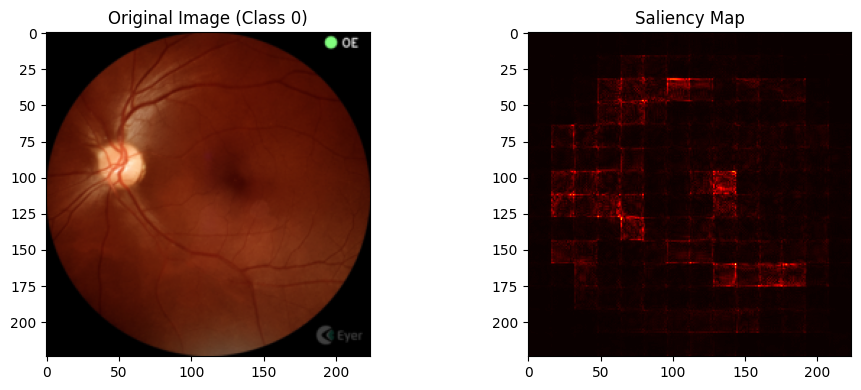

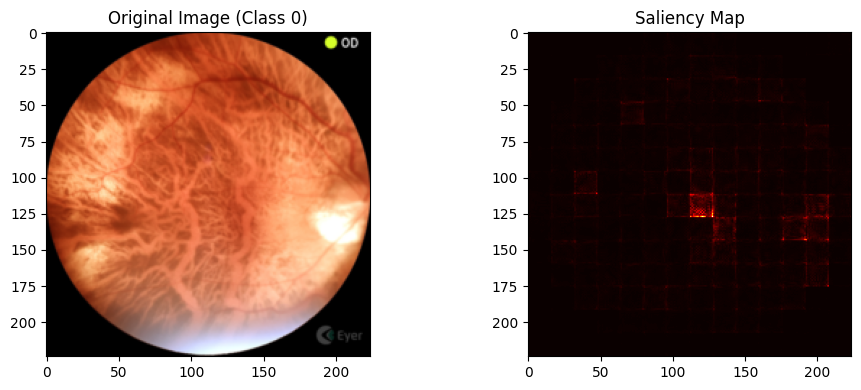

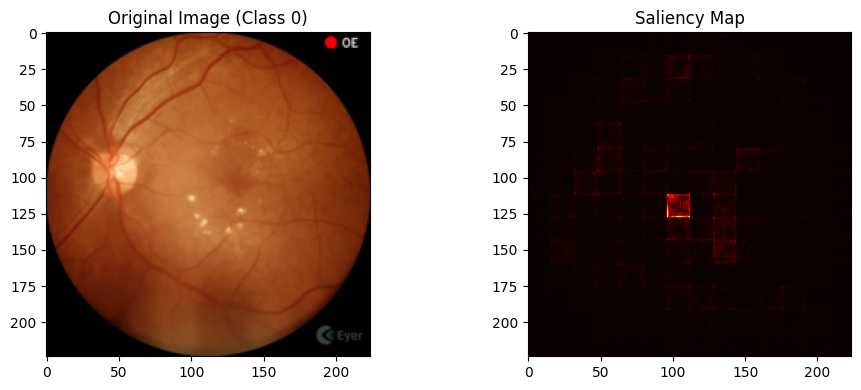

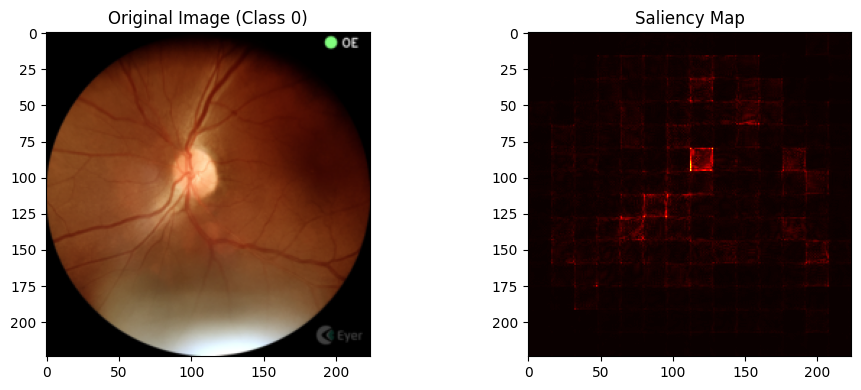

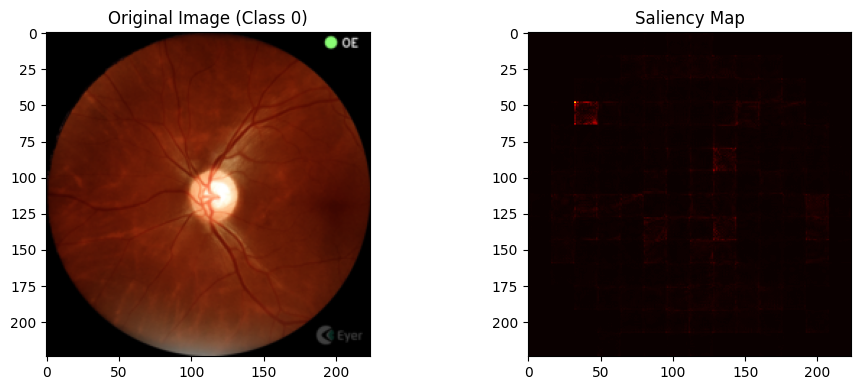

Class 1:


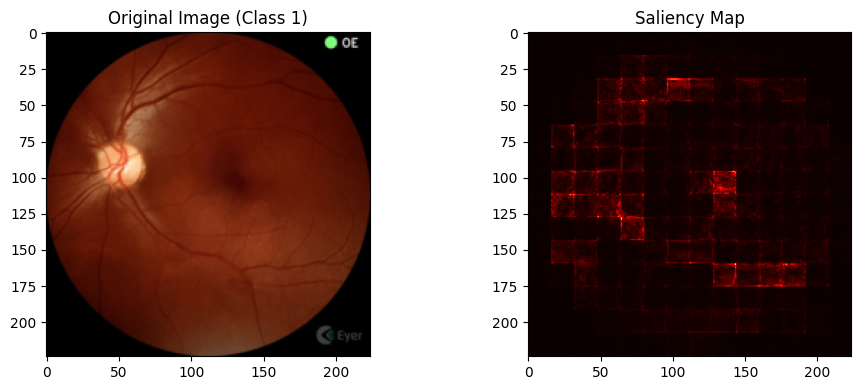

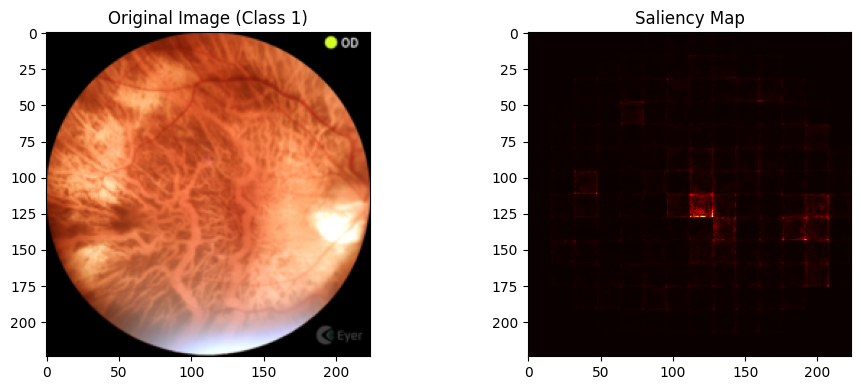

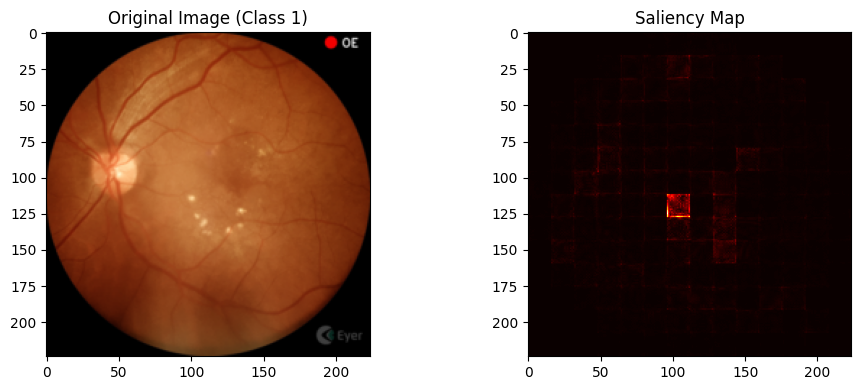

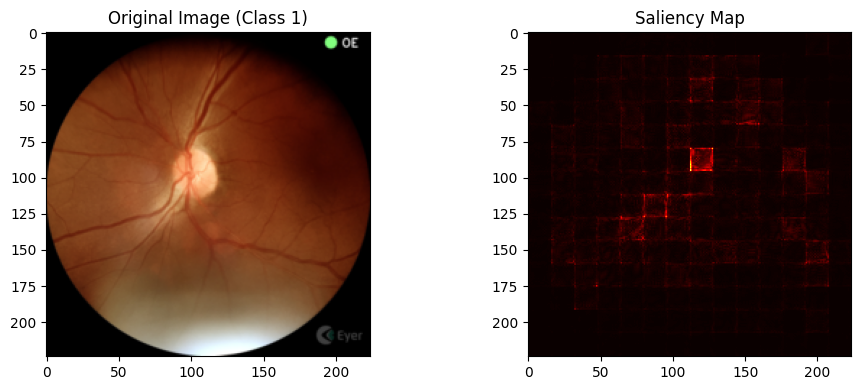

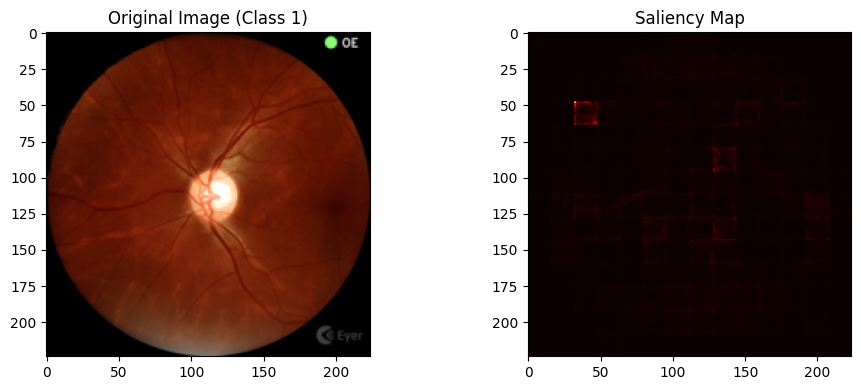

Class 2:


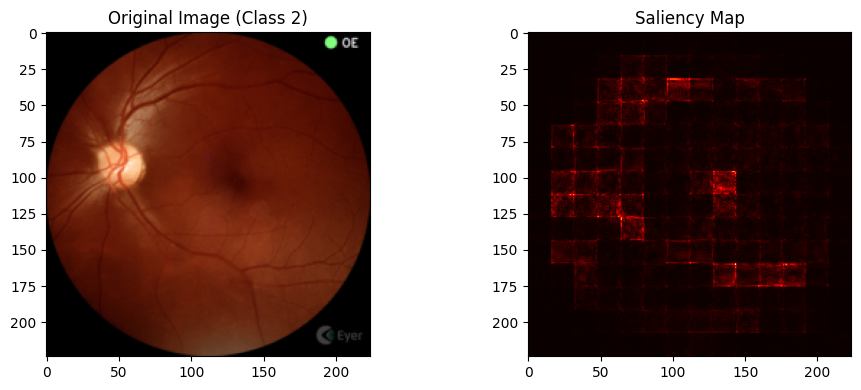

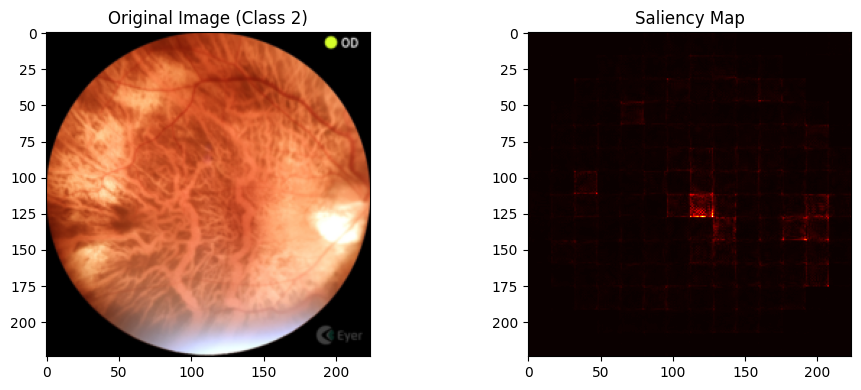

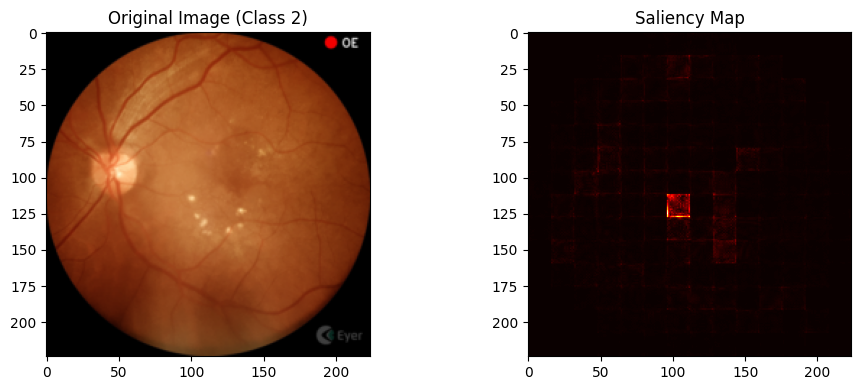

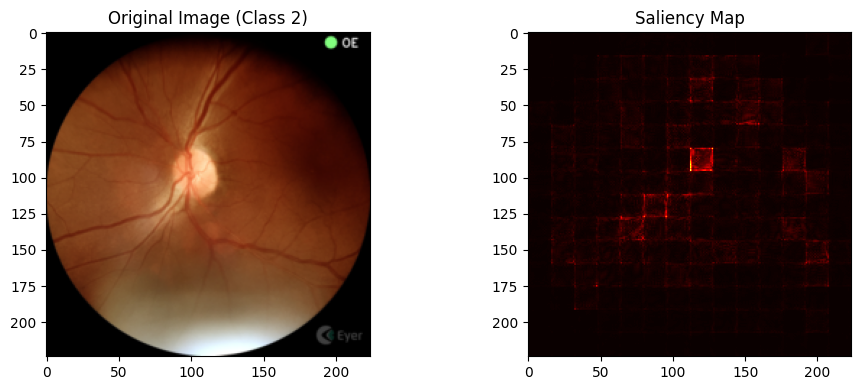

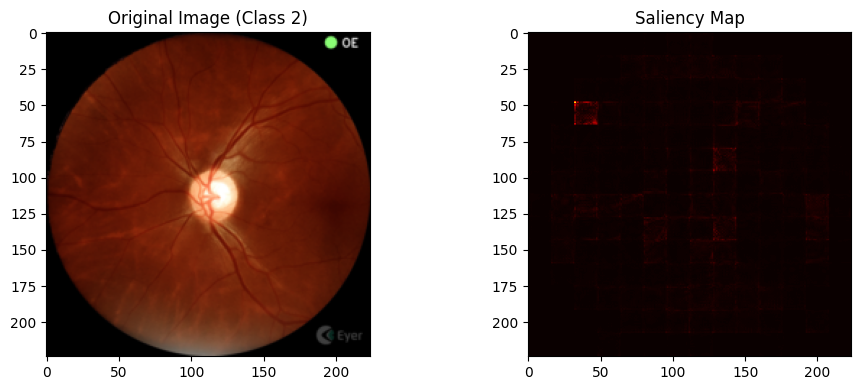

In [15]:
test_new(model, test_dataloader, saliency=True, device=device)